# Data Workflow Lab 2

Proceed with your analysis of the Project 3 data set. You may need to compute new columns as you proceed. Fit one or more linear models to the data, investigate model fits and outliers, use regularization when appropriate.

### Learning objectives
- Perform exploratory analysis
- Generate correlation matrix of the features
- Generate linear regression models
- Evaluate model fit

If appropriate for your models and featuers:
- Use [feature selection](http://scikit-learn.org/stable/modules/feature_selection.html) to pick the best features
- Try different regularization options

In [221]:
% matplotlib inline

from collections import defaultdict
import datetime

from matplotlib import pyplot as plt
# Make the plots bigger
plt.rcParams['figure.figsize'] = 10, 10
import seaborn as sns

import numpy as np
import pandas as pd
from sklearn import linear_model, preprocessing

In [222]:
# Load the data from the previous lab
# If you changed the name you'll need to edit the next line
sales = pd.read_csv("../../assets/datasets/sales.csv")

In [223]:
print(sales.info())
print(sales.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1193 entries, 0 to 1192
Data columns (total 15 columns):
Unnamed: 0                        1193 non-null int64
Store Number                      1193 non-null int64
City                              1193 non-null object
2015 Sales                        1193 non-null float64
2015 Sales mean                   1193 non-null float64
County Number                     1193 non-null int64
Price per Liter mean              1193 non-null float64
Zip Code                          1193 non-null object
2015 Volume Sold (Liters)         1193 non-null float64
2015 Volume Sold (Liters) mean    1193 non-null float64
2015 Margin mean                  1193 non-null float64
2015 Sales Q1                     1193 non-null float64
2016 Sales Q1                     1178 non-null float64
First Date                        1193 non-null object
Last Date                         1193 non-null object
dtypes: float64(8), int64(3), object(4)
memory usage: 139.9+ KB

In [224]:
# correct town with zip code 712-2
sales[sales['Zip Code'] == '712-2']

,Unnamed: 0,Store Number,City,2015 Sales,2015 Sales mean,County Number,Price per Liter mean,Zip Code,2015 Volume Sold (Liters),2015 Volume Sold (Liters) mean,2015 Margin mean,2015 Sales Q1,2016 Sales Q1,First Date,Last Date
550,550,4307,DUNLAP,136462.84,79.385015,43,18.198004,712-2,9249.14,5.380535,26.515887,33904.7,52790.5,2015-01-07,2016-03-29


In [225]:
# a web search reveals Dunlap is 51529. Correct the error
sales.ix[550, 'Zip Code'] = '51529'

In [226]:
# drop 'Unnamed: 0'
sales.drop('Unnamed: 0', axis = 1, inplace = True)

# convert dates
sales[['First Date', 'Last Date']] = sales[['First Date', 'Last Date']].apply(pd.to_datetime,yearfirst = True)

# convert 'Store Number', 'County Number', and Zip Code to categorical data
sales['Store Number'] = sales['Store Number'].astype('category')
sales['County Number'] = sales['County Number'].astype('category')
sales['Zip Code'] = sales['Zip Code'].astype('category')

# add dummy variable columns to the data
categories = ['Store Number', 'County Number', 'Zip Code']
for category in categories:
    series = sales[category]
    dummies = pd.get_dummies(series, prefix=category)
    sales = pd.concat([sales, dummies], axis=1)

In [278]:
# there are a few numbers distorting the values:
# 108, Price per Liter mean values

sales.ix[108, 'Price per Liter mean'] = sales['Price per Liter mean'].mean()

for column in sales.columns:
    if sales[column].isnull().values.any():
        print (column)
        
for row in sales['2016 Sales Q1']:
    if sales.ix[row, '2016 Sales Q1'] == np.NaN:
        print (row)

2016 Sales Q1


TypeError: cannot do label indexing on <class 'pandas.indexes.numeric.Int64Index'> with these indexers [337804.05] of <class 'numpy.float64'>

## Exploratory Analysis
Make some plots, look at correlations, etc.

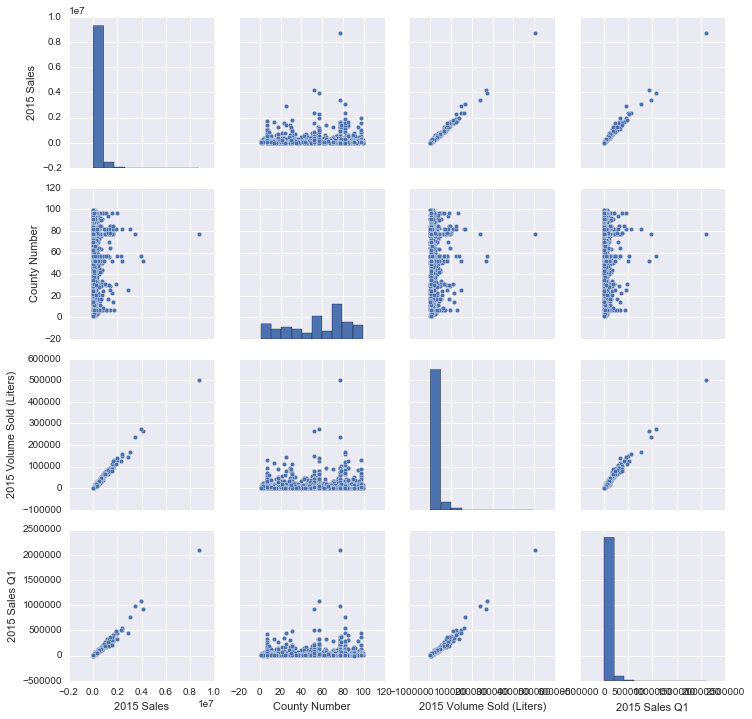

In [236]:
sns.pairplot(sales, vars = ["2015 Sales",                   
"County Number", "2015 Volume Sold (Liters)", "2015 Sales Q1"])

Row 123, refers to Store Number 2633, is data for a supermarket chain location (Des Moines #3 Hy-Vee). Therefore we can reasonable remove it. The second highest-grossing store is at row 974, Store Number 4829, which is a dedicated liquor store (Central City Liquors); we must keep this row.

In [237]:
sales.drop(123, inplace = True)

ValueError: labels [123] not contained in axis

# Compute correlations

In [238]:
sales.corr()

,2015 Sales,2015 Sales mean,Price per Liter mean,2015 Volume Sold (Liters),2015 Volume Sold (Liters) mean,2015 Margin mean,2015 Sales Q1,2016 Sales Q1,Store Number_2106,Store Number_2113,...,Zip Code_52776,Zip Code_52777,Zip Code_52778,Zip Code_52801,Zip Code_52802,Zip Code_52803,Zip Code_52804,Zip Code_52806,Zip Code_52807,Zip Code_56201
2015 Sales,1.000000,0.309294,0.185972,0.991526,0.365445,0.309414,0.988987,0.160560,0.077059,-0.008628,...,-0.011732,-0.013117,-0.016067,-0.013825,-0.016556,-0.004599,0.035314,-0.001678,0.088129,-0.012328
2015 Sales mean,0.309294,1.000000,0.178216,0.293792,0.942895,0.999996,0.284581,0.029338,0.027225,-0.011525,...,-0.006501,-0.012048,-0.014216,0.686698,-0.019745,0.014979,0.010876,-0.005086,0.041055,0.009063
Price per Liter mean,0.185972,0.178216,1.000000,0.139302,0.001961,0.177374,0.170715,-0.008977,0.013995,0.004338,...,0.020351,-0.018900,-0.022337,0.065404,0.024447,0.043839,0.040655,0.006533,0.049667,-0.005163
2015 Volume Sold (Liters),0.991526,0.293792,0.139302,1.000000,0.368105,0.294005,0.983683,0.178333,0.079318,-0.008940,...,-0.013813,-0.014276,-0.016860,-0.015340,-0.017234,-0.008297,0.034444,0.001178,0.087960,-0.013595
2015 Volume Sold (Liters) mean,0.365445,0.942895,0.001961,0.368105,1.000000,0.943478,0.346878,0.032888,0.033877,-0.015450,...,-0.015699,-0.015335,-0.020584,0.536681,-0.026612,0.010712,0.007016,-0.003188,0.042412,0.011580
2015 Margin mean,0.309414,0.999996,0.177374,0.294005,0.943478,1.000000,0.284669,0.029261,0.027170,-0.011543,...,-0.006548,-0.012077,-0.014286,0.686002,-0.019875,0.014871,0.010734,-0.005124,0.041015,0.009015
2015 Sales Q1,0.988987,0.284581,0.170715,0.983683,0.346878,0.284669,1.000000,0.151570,0.078881,-0.007416,...,-0.011696,-0.012936,-0.014243,-0.012449,-0.014749,-0.002660,0.032644,-0.002439,0.079918,-0.011919
2016 Sales Q1,0.160560,0.029338,-0.008977,0.178333,0.032888,0.029261,0.151570,1.000000,0.064266,-0.006840,...,-0.013615,-0.008079,-0.013521,NaN,0.000201,-0.023413,0.000964,0.003298,0.009911,-0.008007
Store Number_2106,0.077059,0.027225,0.013995,0.079318,0.033877,0.027170,0.078881,0.064266,1.000000,-0.000840,...,-0.001188,-0.000840,-0.001188,-0.000840,-0.002382,-0.001881,-0.002665,-0.002382,-0.002527,-0.000840
Store Number_2113,-0.008628,-0.011525,0.004338,-0.008940,-0.015450,-0.011543,-0.007416,-0.006840,-0.000840,1.000000,...,-0.001188,-0.000840,-0.001188,-0.000840,-0.002382,-0.001881,-0.002665,-0.002382,-0.002527,-0.000840


In [239]:
# Fit a linear model
columns = ['2015 Sales', '2015 Sales mean', 'Price per Liter mean',
       '2015 Volume Sold (Liters)', '2015 Volume Sold (Liters) mean',
       '2015 Margin mean', '2015 Sales Q1']
X = sales[columns]
y = sales['2016 Sales Q1']

lm = linear_model.LinearRegression()
model = lm.fit(X, y)
predictions = model.predict(X)

# Plot the data and the best fit line

# Compute the model fit


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# Predict Total 2016 sales, compare to 2015


In [ ]:
# Try per zip code or city to get better resolution



In [ ]:
# Filter out stores that opened or closed throughout the year
# If this wasn't done already


In [ ]:
# Fit another model

# Compute the model fit


In [ ]:
# Predict Total 2016 sales, compare to 2015
